# eQTL Processing

In [1]:
import glob
import os
import random
random.seed(20151226)
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_processing')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_processing')
cpy.makedir(private_outdir)

In [2]:
exp = pd.read_table(os.path.join(
        ciepy.root, 'output', 'eqtl_input', 
        'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), 
                    index_col=0)

## Results

In [36]:
def process_eqtl_results(eqtl_dy, out_dy):
    # This calculates empirical p-values based on the p-values from permutations.
    cpy.makedir(out_dy)
    min_fns = glob.glob(os.path.join(eqtl_dy, '*', 'minimum_pvalues.tsv'))
    min_fns = pd.Series(min_fns, index=[fn.split(os.path.sep)[-2] for fn in min_fns])
    fn = os.path.join(out_dy, 'pvalues.tsv')
    if os.path.exists(fn):
        pvals = pd.read_table(fn, index_col=0,
                              header=None, squeeze=True)
    else:
        pvals = pd.Series()
    fn = os.path.join(out_dy, 'most_sig.tsv')
    if os.path.exists(fn):
        ms = pd.read_table(fn, index_col=0)
    else:
        ms = pd.DataFrame()
    new_pvals = []
    new_genes = []
    most_sig = []
    most_sig_genes = []

    min_fns = min_fns[set(min_fns.index) - set(pvals.index)]
    for fn in min_fns.values:
        g = fn.split(os.path.sep)[-2]
        new_genes.append(g)
        res_fn = os.path.join(os.path.split(fn)[0], '{}.tsv'.format(g))
        res = ciepy.read_emmax_output(res_fn)
        min_pvals = pd.read_table(fn, header=None, squeeze=True)
        p = (1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1)
        new_pvals.append(p)
        t = res[res.PVALUE == res.PVALUE.min()]
        most_sig_genes += [g] * t.shape[0]
        most_sig += list(t.values)
    if len(min_fns) == 0:
        g = pvals.index[0]
        res_fn = os.path.join(eqtl_dy, g, '{}.tsv'.format(g))
        res = ciepy.read_emmax_output(res_fn)
    new_pvals = pd.Series(new_pvals, index=new_genes)
    if new_pvals.shape[0] > 0:
        pvals = pd.concat([pvals, new_pvals])
    pvals.to_csv(os.path.join(out_dy, 'pvalues.tsv'), sep='\t')

    if len(most_sig) > 0:    
        most_sig = pd.DataFrame(most_sig, index=most_sig_genes,
                                columns=res.columns)
        most_sig.columns = [x.lower() for x in most_sig.columns]
        most_sig['chrom'] = 'chr' + most_sig.chrom.astype(str)
        most_sig['coord'] = most_sig.beg
        most_sig['loc'] = most_sig.chrom + ':' + most_sig.coord.astype(str)
        most_sig['gene'] = most_sig.index
        most_sig = most_sig[['chrom', 'beg', 'end', 'loc', 'gene', 'marker_id', 'ns', 'ac', 
                             'callrate', 'genocnt', 'maf', 'stat', 'pvalue', 'beta',
                             'sebeta', 'r2']]
        most_sig.columns = ['chrom', 'start'] + list(most_sig.columns[2:])
        most_sig['start'] -= 1
        most_sig.ix[most_sig.marker_id.apply(lambda x: 'CNV' in x), 'vtype'] = 'cnv'
        t = most_sig.ix[most_sig.vtype == 'cnv', 'marker_id'].apply(lambda x: int(x.split('_')[-1]))
        t.index = most_sig.ix[most_sig.vtype == 'cnv', 'marker_id']
        most_sig.ix[most_sig.vtype == 'cnv', 'end'] = t[most_sig.ix[most_sig.vtype == 'cnv', 'marker_id']].values
        most_sig['ref'] = most_sig.marker_id.apply(lambda x: x.split('_')[1].split('/')[0])
        most_sig['alt'] = most_sig.marker_id.apply(lambda x: x.split('_')[1].split('/')[1])
        most_sig['length'] = most_sig.apply(lambda x: max(len(x['ref']), len(x['alt'])), axis=1)
        most_sig['length'] = (most_sig.ref.apply(lambda x: len(x)) - most_sig.alt.apply(lambda x: len(x))).abs()
        most_sig['vtype'] = 'snp'
        t = most_sig.ix[most_sig.vtype == 'cnv', 'end'] - most_sig.ix[most_sig.vtype == 'cnv', 'start']
        t.index = most_sig.ix[most_sig.vtype == 'cnv', 'marker_id']
        most_sig.ix[most_sig.vtype == 'cnv', 'length'] = t[most_sig.ix[most_sig.vtype == 'cnv', 'marker_id']].values
        most_sig.ix[most_sig.ref.apply(lambda x: len(x)) > most_sig.alt.apply(lambda x: len(x)), 'vtype'] = 'del'
        most_sig.ix[most_sig.ref.apply(lambda x: len(x)) < most_sig.alt.apply(lambda x: len(x)), 'vtype'] = 'ins'
        most_sig = pd.concat([ms, most_sig])

    else:
        most_sig = ms
    most_sig.to_csv(os.path.join(out_dy, 'most_sig.tsv'), sep='\t')
    return most_sig

In [ ]:
a = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/run_eqtl_analysis/results'
most_sig_secondary = process_eqtl_results(a, outdir)

In [41]:
a = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/run_eqtl_analysis/results2'
b = os.path.join(outdir, 'secondary_eqtls')
most_sig_secondary = process_eqtl_results(a, b)

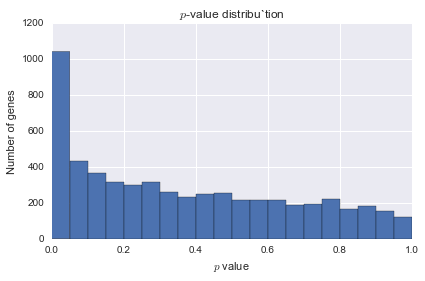

In [53]:
pvals.hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('$p$-value distribu`tion')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'p_value_hist.pdf'))

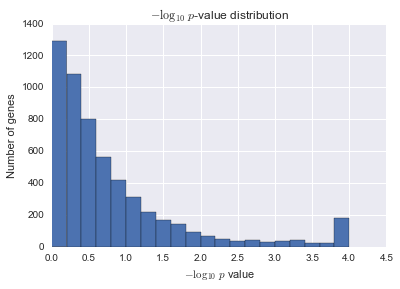

In [54]:
(-np.log10(pvals)).hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$-\log_{10}$ $p$ value')
plt.title('$-\log_{10}$ $p$-value distribution');

## FDR Correction

In [85]:
def qvalue(pvals, summary=True, plot=True):
    """Use the R qvalue package to adjust pvalues. pvals should be a pandas
    Series with gene names as the index."""
    ro.r('suppressMessages(library(qvalue))')
    ro.globalenv['pvals'] = pvals
    ro.r('qobj = qvalue(p=pvals, fdr.level=0.05)')
    ro.r('qvalues <- qobj$qvalues')
    ro.r('pi0 <- qobj$pi0')
    ro.r('lfdr <- qobj$lfdr')
    ro.r('sig <- qobj$significant')
    qvalues = ro.globalenv['qvalues']
    pi0 = ro.globalenv['pi0']
    lfdr = ro.globalenv['lfdr']
    sig = ro.globalenv['sig']
    qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                              index=['pvalue', 'qvalue', 'sig'],
                              columns=pvals.index).T
    qvalue_res['sig'] = qvalue_res.sig.astype(bool)
    qvalue_res = qvalue_res.sort_values(['qvalue'])
    qvalues = pd.Series(list(qvalues), index=pvals.index)
    qvalue_res.index.name = None
    if summary:
        ro.r('summary(qobj)')
    if plot:
        ro.r('plot(qobj)')
    return qvalue_res


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.4031075	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value     2555   3284  4319   5125  5971 7127 17765
q-value        0   3000  4007   4712  5628 7109 17769
local FDR      0   2555  3165   3446  3742 4277 17769



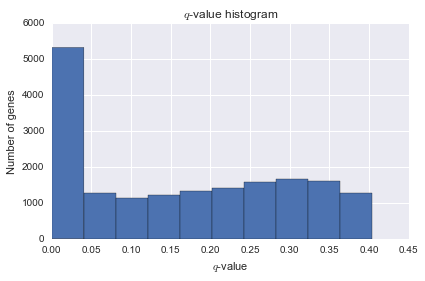

In [93]:
pvals = pd.read_table(os.path.join(outdir, 'pvalues.tsv'), squeeze=True, header=None, index_col=0)
qvalue_res = qvalue(pvals)
qvalue_res.to_csv(os.path.join(outdir, 'qvalues.tsv'), sep='\t')

qvalue_res.qvalue.hist()
plt.title('$q$-value histogram')
plt.ylabel('Number of genes')
plt.xlabel('$q$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'q_value_hist.pdf'))


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.4683741	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1   <1
p-value      179    303   531    770  1040 1470 5627
q-value        0      0   308    415   540  873 5628
local FDR      0      0   227    275   339  429 5614



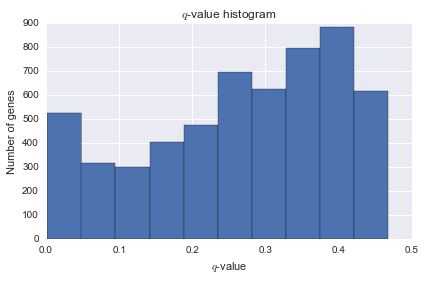

In [95]:
pvals = pd.read_table(os.path.join(outdir, 'secondary_eqtls', 'pvalues.tsv'), squeeze=True, header=None, index_col=0)
qvalue_res_secondary = qvalue(pvals)
qvalue_res_secondary.to_csv(os.path.join(outdir, 'secondary_eqtls', 'qvalues.tsv'), sep='\t')

qvalue_res_secondary.qvalue.hist()
plt.title('$q$-value histogram')
plt.ylabel('Number of genes')
plt.xlabel('$q$-value')
plt.tight_layout()

## Most Significant Variant per Gene

It can be useful to define the most significant variant per gene
for various analyses. I've already done that except sometimes there
are ties. I'll choose just one variant per gene here so that I can 
use a consistent set of most significant variants in other analyses.

In [151]:
fn = os.path.join(outdir, 'most_sig_single.tsv')
if not os.path.exists(fn):
    t = qvalue_res.copy(deep=True)
    t.columns = ['{}_gene'.format(x) for x in t.columns]
    most_sig_single = most_sig.join(t)
    # To choose randomly, I'll assign a random number to each row, then sort
    # by gene and row.
    random.seed(204050)
    most_sig_single['random'] = [random.random() for x in most_sig_single.index]
    most_sig_single = most_sig_single.sort_values(by=['gene', 'random'])
    most_sig_single = most_sig_single.drop_duplicates(subset=['gene'])
    most_sig_single = most_sig_single.drop(['gene', 'random'], axis=1)
    most_sig_single.to_csv(fn, sep='\t')
else:
    most_sig_single = pd.read_table(fn, index_col=0)

I also want to get the most significant SNV per gene since some analyses
won't work with indels. I'll replace indels with a most-significant
SNV (choosing randomly if ties).

In [152]:
out_fn = os.path.join(outdir, 'most_sig_single_snv.tsv')
if not os.path.exists(out_fn):
    indel_genes = most_sig_single[most_sig_single.vtype != 'snp'].index
    new_rows = []
    dy = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results')
    for g in indel_genes:
        fn = os.path.join(dy, g, '{}.tsv'.format(g))
        df = ciepy.read_emmax_output(fn)
        df = df[df.END - df.BEG == 0]
        df = df[df.PVALUE == df.PVALUE.min()]
        new_rows.append(df.ix[random.choice(df.index)])
    tdf = pd.DataFrame(new_rows)
    tdf.index = indel_genes
    tdf.columns = [x.lower() for x in tdf.columns]

    tdf['chrom'] = 'chr' + tdf.chrom.astype(str)
    tdf['coord'] = tdf.beg
    tdf['loc'] = tdf.chrom + ':' + tdf.coord.astype(str)
    tdf['gene'] = tdf.index
    tdf = tdf[['chrom', 'beg', 'end', 'loc', 'gene', 'marker_id', 'ns', 'ac', 
                         'callrate', 'genocnt', 'maf', 'stat', 'pvalue', 'beta',
                         'sebeta', 'r2']]
    tdf.columns = ['chrom', 'start'] + list(tdf.columns[2:])
    tdf['start'] -= 1
    tdf['ref'] = tdf.marker_id.apply(lambda x: x.split('_')[1].split('/')[0])
    tdf['alt'] = tdf.marker_id.apply(lambda x: x.split('_')[1].split('/')[1])
    tdf['length'] = tdf.apply(lambda x: max(len(x['ref']), len(x['alt'])), axis=1)
    tdf['length'] = (tdf.ref.apply(lambda x: len(x)) - tdf.alt.apply(lambda x: len(x))).abs()
    tdf['vtype'] = 'snp'
    tdf = tdf.drop('gene', axis=1)

    t = qvalue_res.copy(deep=True)
    t.columns = ['{}_gene'.format(x) for x in t.columns]
    tdf = tdf.join(t)
    most_sig_single_snv = most_sig_single.drop(indel_genes)
    most_sig_single_snv = pd.concat([most_sig_single_snv, tdf])
    most_sig_single_snv.to_csv(out_fn, sep='\t')
else:
    most_sig_single_snv = pd.read_table(out_fn, index_col=0)
    
fn = os.path.splitext(fn)[0] + '.bed'
if not os.path.exists(fn):
    s = '\n'.join(most_sig_single_snv[['chrom', 'start', 'end', 'loc']].apply(
            lambda x: '\t'.join([str(y) for y in x.values]), axis=1)) + '\n'
    bt = pbt.BedTool(s, from_string=True)
    bt = bt.sort()
    bt.saveas(fn)
    df = bt.to_dataframe()
    df = df.drop_duplicates()
    df.to_csv(os.path.splitext(fn)[0] + '_unique.bed', sep='\t', index=None, header=None)

### LD Pruning

I'm going to LD prune the most-significant SNVs.

In [23]:
snpsnap = None

In [24]:
def get_snpsnap():
    snpsnap_fns = glob.glob('/publicdata/SNPsnap_20151104/EUR_parse/*.tab')
    dfs = []
    for tab in snpsnap_fns:
        df = pd.read_table(tab, index_col=0, low_memory=False)
        tdf = df[['snp_maf', 'dist_nearest_gene_snpsnap_protein_coding',
                  'friends_ld08']]
        tdf.index = 'chr' + tdf.index
        dfs.append(tdf)
    snps = pd.concat(dfs)
    snps['maf_bin'] = pd.cut(snps.snp_maf, np.arange(0, 0.55, 0.05))
    snps['ld_bin'] = pd.cut(np.log10(snps.friends_ld08.replace(np.nan, 0) + 1), 10)
    snps['dist_bin'] = pd.cut(np.log10(snps.dist_nearest_gene_snpsnap_protein_coding
                                       + 1), 10)
    snps = snps[['maf_bin', 'ld_bin', 'dist_bin']]
    return snps

In [ ]:
fn = os.path.join(outdir, 'sig_snv_independent.tsv')
if not os.path.exists(fn):
    if snpsnap is None:
        snpsnap = get_snpsnap()
    ld_beds = glob.glob('/publicdata/1KGP_20151103/LD/tabix/*EUR*.bed.gz')
    ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds], ld_beds))
    sig = most_sig_single_snv[most_sig_single_snv.sig_gene]
    sig = sig.drop_duplicates(subset=['loc'])
    sig = sig[['chrom', 'start', 'end', 'pvalue']]
    sig.index = sig.chrom + ':' + sig.end.astype(str)
    indep = cpb.analysis.ld_prune(sig, ld_beds, snvs=list(snpsnap.index))
    indep.to_csv(fn, sep='\t')
else:
    indep = pd.read_table(fn, index_col=0)
    
fn = os.path.splitext(fn)[0] + '.bed'
if not os.path.exists(fn):
    s = '\n'.join(indep[['chrom', 'start', 'end', 'pvalue']].apply(
            lambda x: '\t'.join([str(y) for y in x.values]), axis=1)) + '\n'
    bt = pbt.BedTool(s, from_string=True)
    bt = bt.sort()
    bt.saveas(fn)

## Significant Variant-Gene Pairs

I'll identitify significant variant-gene pairs the same way that GTEx does. Basically,
I need to find what permutation $p$-value maps to a $q$-value of 0.05. Then for each 
gene. I find out what nominal $p$-value maps to that permutation $p$-value. All variants
with $p$ less than this nominal $p$-value are considered significant.

I'll use an IPython cluster to speed up the calculation of the permutation $p$-values.
This code took several hours to run with 13 engines.

In [ ]:
def calc_perm_pvalues(g, perm_pval):
    fn = min_fns[g]
    res_fn = os.path.join(os.path.split(fn)[0], '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(res_fn).dropna(subset=['PVALUE'])
    min_pvals = pd.read_table(fn, header=None, names=['pvalue'])
    min_pvals['null'] = True
    df = pd.DataFrame({'pvalue':res.PVALUE, 'null':False}).drop_duplicates().dropna()
    t = pd.concat([df, min_pvals])
    t.sort_values(by=['pvalue'], inplace=True)
    t['num_null'] = t.null.cumsum()
    t['perm_pval'] = (t.num_null + 1) / t.null.sum()
    t = t[t.null == False]
    t = t.drop(['null', 'num_null'], axis=1)
    res = res.merge(t, left_on='PVALUE', right_on='pvalue')
    res = res[res.perm_pval < perm_pval]
    res['gene'] = g
    return res
    
out_fn = os.path.join(outdir, 'gene_variant_pairs.tsv')
if not os.path.exists(out_fn):
    # Get permutation p-value cutoff that maps to q = 0.05. I'll do this by finding
    # the gene whose q-value is closest to 0.05 and using its p-value.
    diff = qvalue_res.qvalue - 0.05
    perm_pval = qvalue_res.ix[diff[diff.abs() == diff.abs().min()].index[0], 'pvalue']

    gene_variant_pairs = []

    min_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', 
                                     '*', 'minimum_pvalues.tsv'))
    min_fns = pd.Series(min_fns, index=[fn.split(os.path.sep)[-2] for fn in min_fns])
    for g in qvalue_res[qvalue_res.sig].index:
        tdf = calc_perm_pvalues(g, perm_pval)
        gene_variant_pairs.append(tdf)
        
    gene_variant_pairs = pd.concat(gene_variant_pairs)
    gene_variant_pairs.index = range(gene_variant_pairs.shape[0])
    gene_variant_pairs.columns = [x.lower() for x in gene_variant_pairs.columns]
    gene_variant_pairs['chrom'] = 'chr' + gene_variant_pairs['chrom'].astype(str)
    gene_variant_pairs.to_csv(out_fn, sep='\t', index=None)
else:
    gene_variant_pairs = pd.read_table(out_fn)

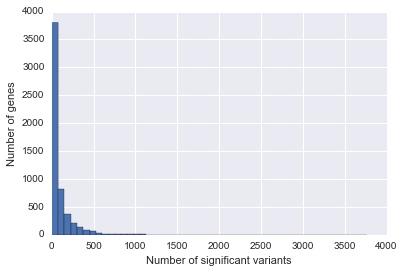

In [28]:
vc = gene_variant_pairs.gene.value_counts()
vc.hist(bins=50)
plt.ylabel('Number of genes')
plt.xlabel('Number of significant variants');

## Combined Results

I want to make a file with all EMMAX results combined. I am going to 
sort this file by position and $p$-value. This will allow me to 
collect some stats like the smallest $p$-value observed for each SNV,
how many times a SNV was tested, etc.

I'll use the IPython cluster to sort the individual output files then
merge them using `sort -m`. This is much faster than concatenating and
sorting though the merging still takes a few hours.

In [ ]:
out = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    dy = os.path.join(outdir, 'tmp')
    cpy.makedir(dy)
    fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 
                                 'results', 'ENS*', 'ENS*.tsv'))
    commands = ['sort -k1,1 -k2,2n -k3,3n -k11,11n {} | grep -v ^# | '
                'awk \'{{print $0"\t{}"}}\' > {}'.format(x, x.split('/')[-2], os.path.join(dy, os.path.split(x)[1]))
                for x in fns]
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    with dview.sync_imports():
        import subprocess
    dview.scatter('commands', commands)
    %px y = [subprocess.check_call(i, shell=True) for i in commands]
    c = 'sort -m -k1,1 -k2,2n -k3,3n -k11,11n {} | bgzip -c > {}'.format(os.path.join(dy, '*'), out)
    subprocess.check_call(c, shell=True)
    c = 'tabix -p bed {}'.format(out)
    subprocess.check_call(c, shell=True)
    c = 'rm -r {}'.format(dy)
    subprocess.check_call(c, shell=True)

Cluster has 11 engines.
importing subprocess on engine(s)


In [ ]:
out = os.path.join(outdir, 'top_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    i = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
    c = ("zcat {} | awk 'a!~$1 || b!~$2 || c!~$3 ; {{a=$1}} {{b=$2}} {{c=$3}}' | "
         "bgzip -c > {}".format(i, out))
    subprocess.check_call(c, shell=True)
    c = 'tabix -p bed {}'.format(out)
    subprocess.check_call(c, shell=True)

In [ ]:
3 +

## Pseudoheritability

These pseudoheratibility estimates may not be that accurate because I've 
regressed out the PEER factors which could remove broad genetic effects
on expression. I probably want to re-run EMMAX without the PEER factors 
to estimate heritability.

In [ ]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing',
                  'pseudoheritability.tsv')
if os.path.exists(fn):
    ph = pd.read_table(fn, index_col=0)
    todo = set(pvals.index) - set(ph.index)
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])
else:
    todo = list(ph.index)
    ph = pd.DataFrame(columns=['observed', 'mean_permuted', 'median_permuted'])
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])

for i in new_ph.index:
    new_ph.ix[i, 'observed'] = float(open(os.path.join(
            ciepy.root, 'private_output', 'run_eqtl_analysis', 'results', i, 
            '{}.reml'.format(i))).read().split('\n')[5].split()[1])
    fn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 
                      'results', i, 'permuted_reml.tsv')
    df = pd.read_table(fn, low_memory=False)
    new_ph.ix[i, 'mean_permuted'] = df.h2.mean()
    new_ph.ix[i, 'median_permuted'] = df.h2.median()
ph = pd.concat([ph, new_ph])
ph.to_csv(fn, sep='\t')